# Predizione Indice Di Borsa: NASDAQ
## Autori: Luca Morlino e Valerio Di Zio


## Descrizione del problema
### Cos'è NASDAQ?
Il Nasdaq Composite è l'indice azionario statunitense che comprende titoli nazionali e internazionali in cui sono quotate più di 5.200 società. È stato creato nel 1971 con una base di 100.
Le società che compongono l'indice seguono i criteri di capitalizzazione. Il Nasdaq è un indice molto volatile dove sono integrate le più importanti società tecnologiche del mondo.

### Obiettivo
L'obiettivo generale è quello di creare un algoritmo che preveda il valore di chiusura del titolo a inizio giornata.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
from utility import plot_model_on_data

## Estrazione dati
I dati relativi a ^IXIC vengono scaricati dal servizio [Yahoo! Finance](https://it.finance.yahoo.com/).
Per fare ciò viene utilizzata la libreria yfinance che permette l'estrazione di dati in forma di oggetti Python facilmente interrogabili.
In particolare, la usiamo per ottenere i dati storici in forma di Dataframe Pandas.

In [23]:
import yfinance

- Creiamo un oggetto Ticker che rappresenta uno specifico titolo o indice
- Nel nostro caso il simbolo del Nasdaq con il suo valore in dollari è ^IXIC

In [24]:
nasdaq = yfinance.Ticker("^IXIC")

- Utilizziamo il metodo history per ottenere i dati storici, partendo dal 1 Gennaio 2011 fino al 31 Dicembre 2021.

In [25]:
data = nasdaq.history(start="2001-01-02", end="2021-12-31", actions=False)

Ad esempio, guardiamo i dati relativi agli ultimi 5 giorni dell'anno 2021. 

In [26]:
data.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-23,15544.790039,15697.980469,15528.910156,15653.370117,3918200000
2021-12-27,15696.830078,15871.400391,15696.830078,15871.259766,3730120000
2021-12-28,15895.200195,15901.469727,15757.070312,15781.719727,3623600000
2021-12-29,15794.919922,15821.809570,15679.849609,15766.219727,3694500000
2021-12-30,15758.980469,15868.089844,15729.160156,15741.559570,3732730000


Andiamo a contare il numero di istanze ricavate

In [27]:
data.shape[0]

5283

## Features
Il nostro dataset, inizialmente, ha 5 features:
- Open: è il valore in dollari di una singola azione all'orario di apertura
- High: è il valore massimo in dollari raggiunto durante la giornata
- Low: è il valore minimo in dollari raggiunto durante la giornata
- Close: è il valore in dollari di una singola azione all'orario di chiusura
- Volume: il volume di trading indica (nel nostro caso) il valore in dollari delle azioni scambiate durante la giornata

Per comodità estraiamo una serie per ciascuna colonna, per potersi riferire ad esse con un unico nome.

In [28]:
open = data["Open"]
high = data["High"]
low = data["Low"]
close = data["Close"]
volume = data["Volume"]

## Rappresentazione dei dati
Possiamo tracciare il grafico dell'andamento del prezzo, basandoci sulla feature "Open".

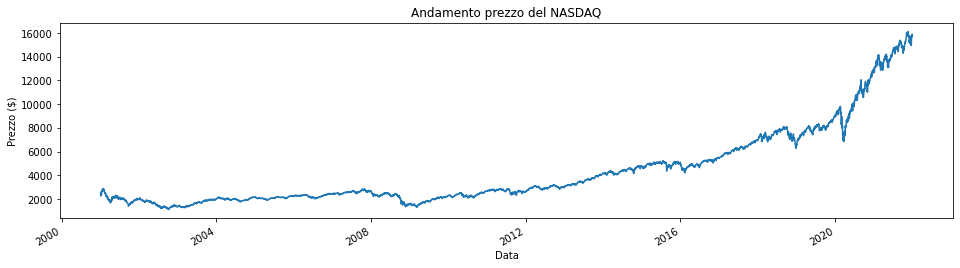

In [29]:
open.plot(figsize=(16,4))
plt.title("Andamento prezzo del NASDAQ")
plt.xlabel("Data")
plt.ylabel("Prezzo ($)");

Utilizzando la libreria plotly è possibile visualizzare in un unico grafico 4 features (Open, High, Low, Close)

In [30]:
import plotly.graph_objects as go

In [31]:
candlestick = go.Candlestick(
                            x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close']
                            )


Il grafico è rappresentato mediante l'utilizzo di Candele, queste ultime rappresentano l'andamento del prezzo di una giornata.

<img src="candlestick.jpeg" alt="Candlestick" style="width:700px;"/>


In [32]:
from ipywidgets.widgets import interact
from datetime import timedelta, datetime

Mostriamo tramite grafico a candele gli ultimi 50 giorni.

In [33]:

termDate = datetime(2021, 12, 31)
DD = timedelta(days=100)
earlier = termDate - DD
earlier_str = earlier.strftime("%Y-%m-%d")

In [34]:
@interact(ymin=(0,13000,500), ymax=(11000,30000,500))
def plot_candlestick(ymin=13000, ymax=17000):    
    fig = go.Figure(data=[candlestick])
    fig.update_layout(
        width=1000, height=700,
        title="Andamento prezzo NASDAQ Candlestick",
        yaxis_title='Prezzo ($)'
    )
    fig.update_xaxes(type="date", range=[earlier_str, termDate])
    fig.update_yaxes(range=[ymin,ymax])
    fig.show()

interactive(children=(IntSlider(value=13000, description='ymin', max=13000, step=500), IntSlider(value=17000, …

Mostriamo ora alcune statistiche generali raggruppate per anno come:
- Media
- Deviazione Standard
- Min e Max
- Quartili


In [35]:
hlm = (high + low) / 2
hlm.groupby(hlm.index.year).describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2001,248.0,2034.761993,301.438942,1420.550049,1862.830002,2008.147522,2161.352478,2860.340088
2002,252.0,1540.405536,251.045797,1123.984985,1333.267487,1458.937500,1768.275024,2066.484924
2003,252.0,1645.938948,232.861727,1266.404968,1409.356247,1662.695007,1882.518753,2005.924988
2004,252.0,1986.535022,96.932764,1759.724976,1913.084991,1985.510010,2061.235046,2180.094971
2005,252.0,2099.567141,85.785227,1905.799988,2051.948761,2087.612488,2162.228760,2268.765015
2006,251.0,2262.655837,110.898229,2024.924988,2172.347473,2275.010010,2338.710022,2462.630005
2007,251.0,2577.249085,112.240827,2351.655029,2489.714905,2572.135010,2656.650085,2838.589966
2008,253.0,2162.027726,344.013830,1339.914978,2055.120056,2299.469971,2397.755005,2629.655029
2009,252.0,1843.543549,269.854111,1290.835022,1606.089981,1839.689972,2098.141205,2290.660034


Guardando i risultati notiamo come i valori della colonna `count` variano a seconda dell'anno, questo accade perché la borsa non è aperta 24/7 ma è chiusa in alcuni giorni, ad esempio i festivi.

Notiamo anche come la media (`mean`) del prezzo aumenta ogni anno, il che rende il NASDAQ un indice solido.

Notiamo anche come nel 2020, l'anno della pandemia, ci sia stata una deviazione standard (`std`) molto alta rispetto agli altri anni.

## Prevedere il valore di chiusura a inizio giornata

La variabile da predire è la features "Close" relativa alla data odierna.

In [36]:
y = close

`high`, `low`, `volume` non possono essere utilizzate in quanto il loro valore non è noto a inizio giornata.
Attualmente l'unica feature utilizzabile è il valore `open`.

In [37]:
features = {"Open" : open}
X = pd.DataFrame(features)

Suddividiamo i dati in un training set e in un validation set con la funzione `split_data`. L'anno inserito verrà utilizzato come test e tutti i precedenti (fino al 2011) verranno utilizzati come training.

In [38]:
def split_data(X, y, split):
    lowerRange = X.index.year < split
    upperRange = (X.index.year > split-1) & (X.index.year < split+1)
    X_train = X.loc[lowerRange]
    y_train = y.loc[lowerRange]
    X_val = X.loc[upperRange]
    y_val = y.loc[upperRange]
    return X_train, X_val, y_train, y_val

## Test 1: Regressione Lineare

Usando training e validation set creati in precedenza addestriamo un modello di regressione lineare e calcoliamo R<sup>2</sup>.

In [39]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X_train, X_val, y_train, y_val = split_data(X, y, 2017)
model.fit(X_train,y_train)
model.score(X_val, y_val)

0.9937613777724708

/opt/homebrew/Caskroom/miniforge/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



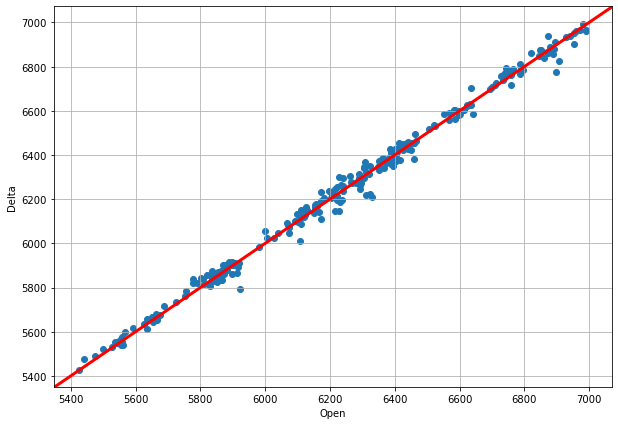

In [40]:
plot_model_on_data(X_val,y_val,model)

Il punteggio R<sup>2</sup> del modello risulta molto alto. Questo è dovuto al fatto che i valore `Open` e `Close` sono molto correlati.

Per avere un riscontro dell'effetiva efficienza del modello calcoliamo il guadagno effettivo di un possibile investitore.

Per far ciò implementiamo un protocollo di trading che dati i valori di chiusura reali e predetti restituisce il guadagno effettivo.

**La cifra investita in questo caso è pari al valore di apertura che varia giornalmente**.

Definiamo la variabile differenza $\Delta_d=C_d-O_d$ tra il valore di chiusura giornaliero $C_d$ e di apertura $O_d$

In [41]:
delta = close - open

- Poniamo questo come il valore che **deve essere predetto** dal modello
- L'investitore agirà in base alla predizione $\hat{\Delta}_d$ in modo analogo a prima
  - se $\hat{\Delta}_d > 0$, acquista un titolo a inizio giornata e lo rivende alla fine
  - se $\hat{\Delta}_d < 0$, vende un titolo a inizio giornata e lo ricompra alla fine

### Importiamo alcune funzioni utili 

Possiamo definire una metrica "guadagno" per validare il modello, che restituisca il guadagno totale di un investitore che opera nel periodo a cui si riferisce il validation set

In [42]:
from utility import gain

Il ROI (Return on investiment) esprime il guadagno di una o più operazioni in borsa in rapporto all'investimento iniziale.

In [43]:
from utility import roi

Definiamo anche una funzione che stampi le metriche di valutazione del modello.

In [44]:
from utility import print_eval

La funzione `prepare_data` restituisce un Dataframe con le colonne indicate e una serie con i valori della variabile da predire corrispondenti alle righe selezionate del Dataframe.

In [45]:
from utility import prepare_data

Addestriamo ora invece un modello di regressione lineare prevedendo il delta e calcoliamo il `gain` e il `ROI`.

In [46]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2017)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Gain: 528.37$
 ROI: 8.477%


Il risultato non è per nulla soddisfacente.

## Aggiungiamo Features
Definiamo alcune funzioni che ci permetteranno di calcolare alcuni indicatori molto comuni nel mondo funanziario.

- MACD:
- SMA:
- EMA:
- RSI:
- MFI:
- ATR:
- FI:

In più aggiungiamo 4 features che possono risultare utili: i prezzi all'apertura traslati di 1,2,3,4 giorni.

In [47]:
features = {
    "Open": open,
    "OpenShift1": open.shift(1),
    "OpenShift2": open.shift(2),
    "OpenShift3": open.shift(3),
    "OpenShift4": open.shift(4),
}

In [48]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Open']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    df = df.join(MACD)
    
    return df

def calculateSMA(data, ndays): 
    SMA = pd.Series(data['Open'].rolling(ndays).mean(), name = 'SMA') 
    return SMA

def addSMA(first, second):
    sma1 = calculateSMA(data, first)
    sma2 = calculateSMA(data, second)
    
    sma = (np.array(sma2) - np.array(sma1)) / np.array(sma2)
    sma = pd.Series(data=sma, index=data.index)
    data[f"SMA{first}-{second}"] = sma
    features[f"SMA{first}-{second}"] = data[f"SMA{first}-{second}"]
    
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

def addEMA(first, second):
    ema1 = calculate_ema(data['Open'], first)
    ema2 = calculate_ema(data['Open'], second)

    ema = (np.array(ema2) - np.array(ema1[(second-first):])) / np.array(ema2)
    ema = pd.Series(data=ema, index=data[(second-1):].index)
    data[f"EMA{first}-{second}"] = ema
    features[f"EMA{first}-{second}"] = data[f"EMA{first}-{second}"]
    
def rsi(close, periods = 14): # il parametro close intende il valore di chiusura del giorno precedente ovvero quello di apertura del giorno corrente
    close_delta = close.diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

def gainForMFI(x):
    return ((x > 0) * x).sum()

def lossForMFI(x):
    return ((x < 0) * x).sum()

def mfi(high, low, close, volume, n=14): # il parametro close intende il valore di chiusura del giorno precedente ovvero quello di apertura del giorno corrente
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gainForMFI, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(lossForMFI, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).shift(1).to_numpy() # spostiamo la colonna di 1 in avanti così da avere per ogni riga il valore dell'MFI del giorno precedente

def atr(high, low, close, n=14):
    high_low = data['High'] - data['Low']
    high_cp = np.abs(data['High'] - data['Close'].shift())
    low_cp = np.abs(data['Low'] - data['Close'].shift())
    df = pd.concat([high_low, high_cp, low_cp], axis=1)
    true_range = np.max(df, axis=1)
    average_true_range = true_range.rolling(14).mean()
    return average_true_range.shift(1) # spostiamo la colonna di 1 in avanti così da avere per ogni riga il valore dell'ATR del giorno precedente

def forceIndex(data, ndays): 
    FI = pd.Series(data['Open'].diff(ndays) * data['Volume'], name = 'ForceIndex') 
    return FI


In [49]:
addEMA(5,20)
addEMA(8,15)
addEMA(20,50)

addSMA(5,20)
addSMA(8,15) #aggiungendo questo indice il guadagno diminuisce negli anni "positivi" e aumenta negli anni "negativi"
addSMA(20,50) #aggiungendo questo indice il guadagno diminuisce negli anni "positivi" e aumenta negli anni "negativi"

data["RSI"] = rsi(data["Open"])
data = computeMACD(data, 12, 26, 9)
data["MFI"] = mfi(data["High"], data["Low"], data["Close"], data["Volume"], 14)
data["ATR"] = atr(data["High"], data["Low"], data["Close"], 14)
data["FI-13"] = forceIndex(data, 13)
data["FI-50"] = forceIndex(data, 50)

features["MACD"] = data["MACD"]
features["RSI"] = data["RSI"] #abbassa i profitti (inutile per ora)
features["MFI"] = data["MFI"] #anche questa sembrerebbe inutile per ora
features["ATR"] = data["ATR"] #STRANO...
features["FI-13"] = data["FI-13"] #assolutamente NO! da risultati orribili (con regressione lineare)
features["FI-50"] = data["FI-50"] #assolutamente NO! da risultati orribili (con regressione lineare)

In [50]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Test delle features
Verifichiamo quali features usare per ottenere il risultato migliore.
Per fare ciò creiamo una funzione che testando TUTTE le combinazioni di features ci restituisce la combinazione migliore.

In [51]:
import itertools

def getBestFeatures(features, model):
    keys = np.array(list(features.keys()))
    mylist = ["1" + "".join(seq) for seq in itertools.product("01", repeat=len(keys)-1)]
    #keys = np.array(['Open', 'OpenShift1', 'OpenShift2', 'OpenShift3','OpenShift4','EMA5-20','EMA8-15','EMA20-50','SMA5-20','SMA8-15','SMA20-50','MACD','RSI','MFI','ATR','FI-13','FI-50'])  
    dict2 = {x:features[x] for x in keys}

    def str2bool(v):
        v_bool = [True]
        for i in v[1:]:
            v_bool.append(i=='1')
        return np.array(v_bool)

    best_ROI = 0;
    best_features = {}

    for i in range(0,len(mylist)):
        dict2 = {x:features[x] for x in keys[str2bool(mylist[i])]}
        X, y = prepare_data(dict2, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, 2017)
        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        if roi(y_val, preds, open) > best_ROI:
            best_ROI = roi(y_val, preds, open)
            best_features = dict2

    return best_features, best_ROI


Verifichiamo come si comporta il nostro modello utilizzando tutte le features disponibili.

In [52]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2017)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Gain: 609.85$
 ROI: 9.784%


In [53]:
import time
start_time = time.time()
new_features, new_ROI = getBestFeatures(features, LinearRegression())
print(new_features)
print(new_ROI)
print("Tempo di esecuzione per la ricerca delle features migliori: %s secondi" % (time.time() - start_time))

{'Open': Date
2001-01-02     2474.159912
2001-01-03     2254.560059
2001-01-04     2593.959961
2001-01-05     2573.110107
2001-01-08     2388.719971
                  ...     
2021-12-23    15544.790039
2021-12-27    15696.830078
2021-12-28    15895.200195
2021-12-29    15794.919922
2021-12-30    15758.980469
Name: Open, Length: 5283, dtype: float64, 'OpenShift2': Date
2001-01-02             NaN
2001-01-03             NaN
2001-01-04     2474.159912
2001-01-05     2254.560059
2001-01-08     2593.959961
                  ...     
2021-12-23    15140.429688
2021-12-27    15319.160156
2021-12-28    15544.790039
2021-12-29    15696.830078
2021-12-30    15895.200195
Name: Open, Length: 5283, dtype: float64, 'OpenShift4': Date
2001-01-02             NaN
2001-01-03             NaN
2001-01-04             NaN
2001-01-05             NaN
2001-01-08     2474.159912
                  ...     
2021-12-23    15036.769531
2021-12-27    14933.000000
2021-12-28    15140.429688
2021-12-29    15319.160156


In [54]:
X, y = prepare_data(new_features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2017)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Gain: 1448.73$
 ROI: 23.242%


Osserviamo che con la selezione delle features migliori abbiamo ottenuto un ROI più alto

### Modelli POSSIBILI

- Regressione Lineare (OK)
- Ridge (OK)
- ElasticNet (OK)
- Logistic Regression (SCARTATA PER ORA)
- XGBoost
- Perceptron
- SVM
- Random Forest
- CatBoost
- LightGBM
- Mini rete neurale (OPZIONALE)

## Test 2: Regressione Ridge

Proviamo ora il modello di regressione Ridge con regolarizzazione per evitare che i coefficienti crescano troppo.

Creiamo un nostro scorer che valuti i modelli in base al ROI

In [55]:
from sklearn.metrics import make_scorer
roi_scorer = make_scorer(roi, open=open, greater_is_better=True)

### Validazione k-fold per serie temporali

- Come alternativa allo split `KFold`, scikit-learn offre il `TimeSeriesSplit(k)` per la nostra situazione in cui vogliamo però mantenere l'ordine temporale in training e validation set

In [56]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(20) #11 anni dal 2011 al 2022

In [57]:
from sklearn.linear_model import Ridge
X, y = prepare_data(new_features, delta)
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Ridge())])

grid = {"linreg__alpha": [0.1, 1, 10, 50]}
gs = GridSearchCV(model, param_grid=grid, scoring=roi_scorer, cv=tss)
gs.fit(X, y)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False).head(3)

NameError: name 'Pipeline' is not defined

- Per la regressione Ridge il parametro migliore è $\alpha$=0.1 con un profitto dopo 11 anni del 6.1%:
- **Ottenendo profitto migliore utilizzando le features selezionate**
- *Utilizzando invece tutte le features otteniamo un profitto del 4.8%*

## Test 3: ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
X, y = prepare_data(features, delta)
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet())])

grid = {"linreg__alpha":  [1, 2, 3, 5], "linreg__l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.5]}
gs = GridSearchCV(model, param_grid=grid, scoring=roi_scorer, cv=tss)
gs.fit(X, y)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False).head(3)

- Per la regressione ElasticNet i parametri migliori sono $\alpha$=3 e L1_RATIO=0.2 con un profitto dopo 11 anni del 7.3%:

- **Ottenendo profitto migliore utilizzando tutte le features**

- *Utilizzando invece le features selezionate otteniamo un profitto del 6.4%*

I risultati ottenuti sono simili, in quanto la regressione ElasticNet permette di penalizzare le variabili irrilevanti, che è lo stesso scopo della nostra funzione: `getBestFeatures()`

## Test 4: Regressione con alberi decisionali

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2017)

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report

rfc = Pipeline([
    ('std', StandardScaler()),
    ('rfc', RandomForestRegressor(n_jobs=-1))
])

parameters = {
    'rfc__n_estimators': [100, 200, 300],
    'rfc__max_depth': [2, 4, 6, 8, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__min_samples_split': [2, 5, 10],
}
    

rfc_gs = GridSearchCV(rfc, parameters, cv=tss, n_jobs=-1, scoring=roi_scorer)
rfc_gs.fit(X_train, y_train)

print('Random Forest GridSearch finish')

In [ ]:
print_eval(X_val,y_val,rfc_gs,open)

In [ ]:
pd.DataFrame(rfc_gs.cv_results_).sort_values("mean_test_score", ascending=False)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
X, y = prepare_data(new_features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2017)

In [ ]:
%%time
# xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=200, verbose_eval=True)
# con 3 variabili di lag xgboost vince con al seguente invocazione ottenendo ROI 113.73%
xgbm = XGBRegressor(objective='reg:squarederror', learning_rate = 0.01577, reg_lambda=0.008, reg_alpha=0.0001, n_estimators=1025, verbose_eval=False)

# segue xgboost con variabili di lag
# xgbm = XGBRegressor(objective='reg:squarederror', learning_rate = 0.001577, reg_lambda=0.0008, reg_alpha=0.0055011, n_estimators=625, verbose_eval=False)

xgbm.fit(X_train, y_train)

In [ ]:
print_eval(X_val, y_val, xgbm, open)

## Test parametri

In [ ]:
model_a = LinearRegression()
model_a.fit(X_train, y_train)
print_eval(X_val, y_val, model_a, open)

In [ ]:
from sklearn.linear_model import Ridge

model_b = Ridge(alpha=10)
model_b.fit(X_train, y_train)
print_eval(X_val, y_val, model_b, open)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

model_c = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])
model_c.fit(X_train, y_train)
print_eval(X_val, y_val, model_c, open)

Vediamo quanto influiscono i parametri relativi alle colonne

In [ ]:
pd.DataFrame({
    "linear": model_a.coef_,
    "ridge": model_b.coef_,
    "scaled": model_c.named_steps["lr"].coef_
}, index=X.columns)

Con la standardizzazione delle feature otteniamo valori su scale simili, che possiamo confrontare alla pari:
- ad es. negli altri modelli il coefficiente di EMA8-15
  è alto in valore assoluto perché i valori di tale variabile sono bassi 
 - nel modello con standardizzazione assumono invece più peso il numero di stanze (`RM`) e la distanza dagli uffici di collocamento (`DIS`)